# Analysis of (Conditional) Mutual Information Estimators Using Forests - Sample Efficiency

In this simulation notebook, we will evaluate the sample efficiency of using forests to estimate
(conditional) mutual information. We will replicate the findings of https://arxiv.org/pdf/2110.13883.pdf. 

The data we will simulate comes from the following distributions for mutual information:

- Helix: X is dependent on Y on a helix
- Sphere: X is dependent on Y
- Uniform: X is dependent on Y
- Gaussian: X is dependent on Y
- independent: X is completely independent of Y

The data we will simulate comes from the following distributions for conditional mutual information:

- Uniform: X is conditionally (in)dependent on Y given Z
- Gaussian: X is conditionally (in)dependent on Y given Z

For each distribution, we will add a varying number of independent dimensions to the data (i.e. sampled from Gaussian distribution).

## Graphical models of the simulation

For our purposes, we are motivated by the feature selection problem in cancer research, where cancer status (1-4 severity) is the outcome variable of interest and certain feature sets (X and W) are possibly high-dimensional sets that may have causal impact on each other. With prior knowledge, we know that cancer status cannot cause any of the features in the feature sets. We are also typically concerned with comparing sets of features conditioned on at most one other feature set. This allows us to enumerate all possible causal DAG settings that match this. We have the following 8 possible DAGs:

1. W is completely independent: $(X \rightarrow Y, W)$
2. W is an observed covariate: $(X \rightarrow Y, X \leftarrow W \rightarrow Y)$
3. W is an observed confounder that explains the correlation between X and Y: $(X, X \leftarrow W \rightarrow Y)$
4. W affects the outcome only: $(X \rightarrow Y, W \rightarrow Y)$
5. W affects the treatment only: $(X \rightarrow Y, W \rightarrow X)$
6. W affects the outcome only but X is independent: $(X, W \rightarrow Y)$
7. W affects the treatment only but X is independent: $(Y, W \rightarrow X)$
8. All are d-separated: $(Y, W, X)$

With these, we assume that there are no other relevant latent confounders that are not controlled for in our experimental design.

# Estimation Methods for Y discrete

1. Direct estimation of entropy using supervised forests:

$$I(X; Y) = H(X) - H(X | Y) = H(Y) - H(Y | X)$$

-> H(Y| X) = clf.predict_proba(X) after fitting forest to (X, Y) pairs
-> H(Y) = empirical entropy calculuation

$$I(X; Y|Z) = H(Y | Z) - H(Y | X, Z)$$

-> Train two forests and directly estimate using pairs of (Y, Z) and (Y, X \cup Z)

2. Indirect estimation of entropy using KSG with unsupervised forests

The (conditional) mutual information KSG estimator just requires training a forest.%load_ext lab_black

In [2]:
%load_ext lab_black

In [6]:
import numpy as np
import scipy
import scipy.spatial
from tqdm import tqdm

from sklearn.neighbors import NearestNeighbors
from sktree.neighbors import forest_distance
import sktree
from sktree.experimental.simulate import (
    simulate_helix,
    simulate_multivariate_gaussian,
    simulate_sphere,
    embed_high_dims,
)
from sktree.experimental.ksg import _compute_radius_nbrs, mutual_info_ksg_nn
from sktree.experimental.mutual_info import (
    entropy_gaussian,
    entropy_weibull,
    cmi_from_entropy,
    mi_from_entropy,
    mi_gaussian,
    cmi_gaussian,
    mi_gamma,
)
from sktree.experimental import mutual_info_ksg, SupervisedInfoForest
from sktree.tree import compute_forest_similarity_matrix
from sktree import (
    UnsupervisedRandomForest,
    UnsupervisedObliqueRandomForest,
    ObliqueRandomForestClassifier,
    ObliqueRandomForestRegressor,
    NearestNeighborsMetaEstimator,
)

from dodiscover.ci import CMITest
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
%load_ext autoreload
%autoreload 2

## Define Hyperparameters of the Simulation

In [8]:
seed = 12345
rng = np.random.default_rng(seed)

In [9]:
n_jobs = -1
n_estimators = 100
feature_combinations = 2.0
n_nbrs = 5

# hyperparameters of the simulation
n_samples = 1000
n_noise_dims = 20
alpha = 0.001

# dimensionality of mvg
d = 3

# for sphere
radius = 1.0

# for helix
radius_a = 0.0
radius_b = 2.0

# manifold parameters
radii_func = lambda: rng.uniform(0, 1)

## Setup a single simulation

Now, to demonstrate what the data would look like fromm a single parameterized simulation, we want to show the entire workflow from data generation to analysis and output value.

In [10]:
# generate helix data
helix_data = simulate_helix(
    radius_a=radius_a,
    radius_b=radius_b,
    alpha=alpha / 2,
    n_samples=n_samples,
    return_mi_lb=True,
    random_seed=seed,
)
P, X, Y, Z, helix_lb = helix_data

# generate sphere data
sphere_data = simulate_sphere(
    radius=radius, alpha=alpha, n_samples=n_samples, return_mi_lb=True, random_seed=seed
)
lat, lon, Y1, Y2, Y3, lb = sphere_data

# simulate multivariate Gaussian
mvg_data = simulate_multivariate_gaussian(d=d, n_samples=n_samples, seed=seed)
data, mean, cov = mvg_data

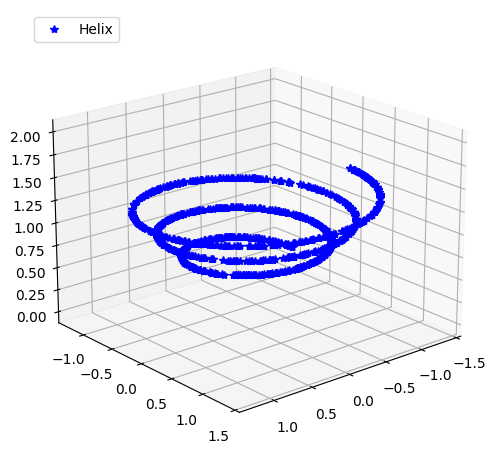

In [11]:
# helix data
fig = plt.figure()
ax1 = fig.add_subplot(111, projection="3d")

ax1.plot(X, Y, Z, "*", c="b", label="Helix")
ax1.legend(loc="upper left")
ax1.axis("equal")
# ax1.set(
#     xlim=[-1, 1],
#     ylim=[-1, 1],
#     zlim=[0.25, 1],
# )
fig.tight_layout()
elev = 20
azim = 50
roll = 0
ax1.view_init(elev, azim, roll)

plt.show()

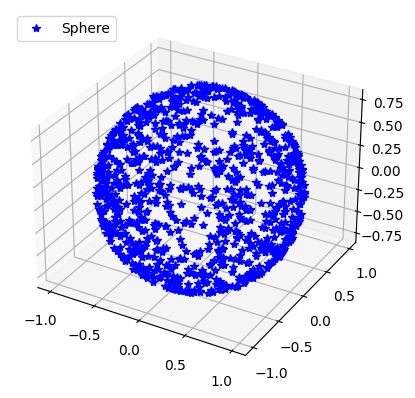

In [12]:
# sphere data
fig = plt.figure()
ax1 = fig.add_subplot(111, projection="3d")

ax1.plot(Y1, Y2, Y3, "*", c="b", label="Sphere")
ax1.legend(loc="upper left")
ax1.axis("equal")

plt.show()

In [13]:
print(cov)
print(np.linalg.eigvals(cov))

[[ 0.31087872  0.01905156 -0.19413813]
 [ 0.01905156  1.21114085  2.27200637]
 [-0.19413813  2.27200637  5.13099624]]
[6.17646933 0.35752001 0.11902648]


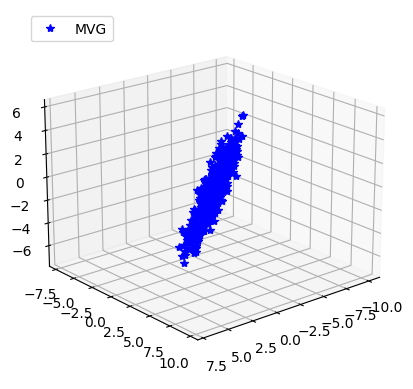

In [14]:
# mvg data
fig = plt.figure()
ax1 = fig.add_subplot(111, projection="3d")

ax1.plot(data[:, 0], data[:, 1], data[:, 2], "*", c="b", label="MVG")
ax1.legend(loc="upper left")
ax1.axis("equal")
elev = 20
azim = 50
roll = 0
ax1.view_init(elev, azim, roll)

plt.show()

In [15]:
# now we will embed in high-dimensions
data, mean, cov = mvg_data
print(data.shape)
X = embed_high_dims(data, n_dims=50, random_state=seed)

(1000, 3)


In [298]:
X = embed_high_dims(data[:, [0]], n_dims=n_noise_dims, random_state=seed)
Y = embed_high_dims(data[:, [1]], n_dims=n_noise_dims, random_state=seed)
Z = embed_high_dims(data[:, [2]], n_dims=n_noise_dims, random_state=seed)
highdim_data = np.hstack((X, Y, Z))

print(X.shape, data.shape)

(1000, 21) (1000, 3)


### Unsupervised KSG approach

In [330]:
# define the forest-based estimator to determine distances
clf = UnsupervisedObliqueRandomForest(
    n_estimators=200,
    feature_combinations=feature_combinations,
    n_jobs=n_jobs,
    random_state=seed,
)

# meta-estimator for nearest-neighbor lookup
est = NearestNeighborsMetaEstimator(
    estimator=clf,
    n_neighbors=n_nbrs,
    algorithm="auto",
    n_jobs=n_jobs,
    force_fit=True,
    verbose=True,
)

data = np.hstack((X, Y))
print(X.shape, Y.shape, data.shape)

(1000, 21) (1000, 21) (1000, 42)


In [320]:
print(cov)

[[ 0.31087872  0.01905156 -0.19413813]
 [ 0.01905156  1.21114085  2.27200637]
 [-0.19413813  2.27200637  5.13099624]]


In [321]:
print(X.shape, Y.shape, data.shape)

(1000, 21) (1000, 21) (1000, 42)


In [322]:
# true MI and CMI
true_mi = mi_gaussian(cov, 1, 2)
true_cmi = cmi_gaussian(cov, 0, 1, 2)
print(true_mi)
print(true_cmi)

0.8879202209746868
0.09749224201325823


In [331]:
geo_ksg_mi = mutual_info_ksg(
    X, Y, nn_estimator=est, n_jobs=n_jobs, k=0.2, verbose=False
)

Finished fitting estimator: UnsupervisedObliqueRandomForest(feature_combinations=2.0, n_estimators=200,
                                n_jobs=-1, random_state=12345)
Finished computing distance matrix: (1000, 1000)
Finished fitting estimator: UnsupervisedObliqueRandomForest(feature_combinations=2.0, n_estimators=200,
                                n_jobs=-1, random_state=12345)
Finished computing distance matrix: (1000, 1000)
Finished computing distance matrix: (1000, 1000)
Computing radius neighbors for 1000 samples
Computing radius neighbors in parallel...
Finished fitting estimator: UnsupervisedObliqueRandomForest(feature_combinations=2.0, n_estimators=200,
                                n_jobs=-1, random_state=12345)
Finished computing distance matrix: (1000, 1000)
Finished computing distance matrix: (1000, 1000)
Computing radius neighbors for 1000 samples
Computing radius neighbors in parallel...


In [329]:
print(geo_ksg_mi)

1.6599834335427683


In [332]:
ksg_mi = mutual_info_ksg_nn(X, Y, n_jobs=n_jobs, k=0.2, verbose=False)
print(ksg_mi)

1.478834083567829


In [300]:
nn_estimator = NearestNeighbors(
    n_neighbors=5, algorithm="kd_tree", p=np.inf, n_jobs=n_jobs
)
ksg_mi = mutual_info_ksg(
    X, Y, nn_estimator=nn_estimator, n_jobs=n_jobs, k=0.3, verbose=False
)
print(ksg_mi)

KeyboardInterrupt: 

In [ ]:
print(ksg_mi)

In [257]:
nn_estimator.fit(data[:, col_idx])

nn = []
for idx, radius in enumerate(radius_per_sample):
    nn_ = nn_estimator.radius_neighbors(
        X=np.atleast_2d(data[:, col_idx]), radius=radius, return_distance=False
    )
    nn.append(nn_[idx])
print(np.array([len(nn_) for nn_ in nn]))

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  1  1  1  1  1  4
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  4  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  7  1  1  1  1  1  1  1  1  1
  1  1  1  1  4  1  1  1  1  1 10  1  1  1  1  1  1  1  1  6  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  6  2  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  6  1  1  1  1  1  1  1  1  5  1
  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  5  1  1  1  7  1  1  1  1  1  4  1  7  1  1  1  1  1  1  1
  1  1  1  1  2  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  1  1
  1  6  1  1  1  1  1  2  1  1  1  1  7  1  1  1  1  1  3  1  1  1  1  1
  1  1  1  1  1  1  1  3  1  1  1  1  1  1  1  1  5  1  1  1  1  1  1  1
  1  1 12  9  1  1  1  1  5  1  1  1  1  1  1  1  1  1  7  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  8  1  1  1  1  1  1  1  1
  6  1  1  2  1  1  1  1  3  1  1  1  1  1  1  1  1

In [256]:
print(nn[])

[array([2])]


In [301]:
cmi_est = CMITest(k=0.3, n_jobs=n_jobs, random_seed=seed)

In [302]:
df_x = pd.DataFrame(X, columns=[f"x{idx}" for idx in range(X.shape[1])])
x_cols = df_x.columns
df_y = pd.DataFrame(Y, columns=[f"y{idx}" for idx in range(Y.shape[1])])
y_cols = df_y.columns
df = pd.concat((df_x, df_y), axis=1)

cmi_est._compute_cmi(df, x_cols, y_cols, set())

1.1180955699940993

### Supervised entropy estimate approach

This is tabled until we get "proba" estimates for regression trees.

In [24]:
estimator = ObliqueRandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)
sup_cmi_est = SupervisedInfoForest(estimator=estimator, y_categorical=False, n_jobs=-1)

In [27]:
y = Y[:, [0]]

sup_cmi_est.fit(X, y)

/Users/adam2392/miniforge3/envs/sktree/lib/python3.9/site-packages/sklearn/utils/validation.py:1189: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(1000, 2) (1000,)


SupervisedInfoForest(estimator=ObliqueRandomForestRegressor(n_jobs=-1),
                     n_jobs=-1)

In [28]:
print(sup_cmi_est.predict_cmi(X))

AttributeError: 'ObliqueRandomForestRegressor' object has no attribute 'predict_proba'

# Final Analysis Across All Possible Parametrizations

Now, we want to analyze Unsup-Forest-KSG, Sup-Forest-KSG, Uncertainty-Forest, and KSG-estimator for MI. Moreover, we can implement all traditional RF and oblique RF.

In [16]:
# fix the number of samples, but increase the number of noise dimensions
n_samples = 1000

n_jobs = -1
n_estimators = 300
feature_combinations = 1.5
k_ratio = 0.2

# semi-parametric
n_nbrs = 0.2

# hyperparameters of the simulation
alpha = 0.01

# dimensionality of mvg
d = 3

n_repeats = 10

noise_dims_grid = np.linspace(0, 100, 21)
print(noise_dims_grid)

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]


In [17]:
X = embed_high_dims(data[:, [0]], n_dims=n_noise_dims, random_state=seed)
Y = embed_high_dims(data[:, [1]], n_dims=n_noise_dims, random_state=seed)
Z = embed_high_dims(data[:, [2]], n_dims=n_noise_dims, random_state=seed)
highdim_data = np.hstack((X, Y, Z))

# true MI and CMI
x_cov_idx = 0
y_cov_idx = 1
z_cov_idx = 2
true_mi = mi_gaussian(cov, y_cov_idx, z_cov_idx)
true_cmi = cmi_gaussian(cov, y_cov_idx, z_cov_idx, x_cov_idx)
print(true_mi)
print(true_cmi)

0.8879202209746868
0.9849302324167128


In [ ]:
true_mis = []
ksg_mis = []
uf_ksg_mis = []
exp_idx = []

# we are just comparing I(X; Y)
for idx in tqdm(range(len(noise_dims_grid))):
    for jdx in range(n_repeats):
        noise_dims = noise_dims_grid[idx].astype(int)
        # simulate multivariate Gaussian
        mvg_data = simulate_multivariate_gaussian(d=d, n_samples=n_samples, seed=seed)
        data, mean, cov = mvg_data

        X = embed_high_dims(data[:, [0]], n_dims=noise_dims, random_state=seed)
        Y = embed_high_dims(data[:, [1]], n_dims=noise_dims, random_state=seed)
        Z = embed_high_dims(data[:, [2]], n_dims=noise_dims, random_state=seed)
        highdim_data = np.hstack((X, Y, Z))

        # true MI and CMI
        x_cov_idx = 0
        y_cov_idx = 1
        z_cov_idx = 2
        true_mi = mi_gaussian(cov, y_cov_idx, z_cov_idx)
        true_cmi = cmi_gaussian(cov, y_cov_idx, z_cov_idx, x_cov_idx)
        # print(true_mi)
        # print(true_cmi)
        # print(X.shape, data.shape)

        #
        data = np.hstack((Y, Z))
        # print(X.shape, Y.shape, data.shape)

        # now estimate both MIs
        # define the forest-based estimator to determine distances
        clf = UnsupervisedObliqueRandomForest(
            n_estimators=n_estimators,
            feature_combinations=feature_combinations,
            n_jobs=n_jobs,
            random_state=seed,
        )

        # meta-estimator for nearest-neighbor lookup
        est = NearestNeighborsMetaEstimator(
            estimator=clf,
            n_neighbors=n_nbrs,
            algorithm="auto",
            n_jobs=n_jobs,
            force_fit=True,
            verbose=False,
        )
        geo_ksg_mi = mutual_info_ksg(
            Y, Z, nn_estimator=est, norm="max", n_jobs=n_jobs, k=k_ratio, verbose=False
        )

        # regular KSG estimator using KD-Tree
        ksg_mi = mutual_info_ksg_nn(
            Y, Z, norm="max", n_jobs=n_jobs, k=k_ratio, verbose=False
        )

        true_mis.append(true_mi)
        uf_ksg_mis.append(geo_ksg_mi)
        ksg_mis.append(ksg_mi)
        exp_idx.append(jdx)

        print(noise_dims, true_mi, geo_ksg_mi, ksg_mi)

  0%|                                                    | 0/21 [00:00<?, ?it/s]

0 0.8879202209746868 1.478113889134514 0.6529995763807932
0 0.8879202209746868 1.5452143822171145 0.6529841351437629
0 0.8879202209746868 1.5452143822171145 0.6529706352793259
0 0.8879202209746868 1.478113889134514 0.6529841351437629
0 0.8879202209746868 1.478113889134514 0.6530034112094718
0 0.8879202209746868 1.5452143822171145 0.6529830247169386
0 0.8879202209746868 1.5452143822171145 0.6529995763807932
0 0.8879202209746868 1.478113889134514 0.6529983653318343
0 0.8879202209746868 1.478113889134514 0.6529995763807932


  5%|█▉                                       | 1/21 [10:03<3:21:09, 603.50s/it]

0 0.8879202209746868 1.5452143822171145 0.6529706352793259
5 0.8879202209746868 0.5671783906639725 1.4280714608103366
5 0.8879202209746868 0.5511450249028176 1.4279783421747254
5 0.8879202209746868 0.5717687178836002 1.4281165521090635
5 0.8879202209746868 0.5556401284712642 1.4280717688192173
5 0.8879202209746868 0.5716710135775518 1.428057542756406
5 0.8879202209746868 0.5556153579646761 1.4279940876385169
5 0.8879202209746868 0.5555442613722619 1.4280186162318564
5 0.8879202209746868 0.5465182725707773 1.4280630786232518
5 0.8879202209746868 0.5668597042746679 1.4280172451354147


 10%|███▉                                     | 2/21 [20:28<3:15:03, 615.96s/it]

5 0.8879202209746868 0.5718044969874825 1.4280046779404625
10 0.8879202209746868 1.0228861561488944 1.5083676411458526
10 0.8879202209746868 1.0399615829188527 1.5083101266465686
10 0.8879202209746868 1.0289657792650555 1.5082978674920664
10 0.8879202209746868 1.0118893246358898 1.5083384726784246
10 0.8879202209746868 1.018909333858094 1.5083099365951362
10 0.8879202209746868 1.0113643762342015 1.5082646293479254
10 0.8879202209746868 1.0249568196911198 1.5083037347810144
10 0.8879202209746868 1.0266125807819062 1.508341318716024
10 0.8879202209746868 1.0165102570517757 1.508246001251342


 14%|█████▊                                   | 3/21 [30:47<3:05:17, 617.67s/it]

10 0.8879202209746868 1.0601800130719106 1.5083428353430275
15 0.8879202209746868 1.823008732530253 1.5412018930045548
15 0.8879202209746868 1.6580264611738436 1.541184128996452
15 0.8879202209746868 1.7552355647843267 1.5413651557722474
15 0.8879202209746868 1.7727696397582449 1.541230557271545
15 0.8879202209746868 1.7058893242546525 1.541231149142849
15 0.8879202209746868 1.7593054777413322 1.5411808955267343
15 0.8879202209746868 1.7887098503270433 1.5412365490526856
15 0.8879202209746868 1.769718708166927 1.5411887228153986
15 0.8879202209746868 1.7113797122014844 1.5412158133558105


 19%|███████▊                                 | 4/21 [40:54<2:53:45, 613.24s/it]

15 0.8879202209746868 1.7721442973626882 1.5411543468786082
20 0.8879202209746868 1.6742599433538246 1.5600469734115183
20 0.8879202209746868 1.5778105836171452 1.5600959692217309
20 0.8879202209746868 1.6364458593232651 1.5600617450768954
20 0.8879202209746868 1.8083178309599166 1.5600938146533263
20 0.8879202209746868 1.7296058741924565 1.5600417301738645
20 0.8879202209746868 1.6482557883218085 1.5602735407836477
20 0.8879202209746868 1.662442786675319 1.5602220164640208
20 0.8879202209746868 1.7211119063087406 1.5600986558533378
20 0.8879202209746868 1.6728106035954013 1.5600258598816552


 24%|█████████▊                               | 5/21 [50:58<2:42:39, 609.98s/it]

20 0.8879202209746868 1.7006908899408213 1.560239522451809
25 0.8879202209746868 1.9484161195333165 1.5717317089480538
25 0.8879202209746868 1.8642225066033458 1.571687650585437
25 0.8879202209746868 2.0402832686348056 1.5717954551082585
25 0.8879202209746868 1.9857364776976674 1.5718321513215852
25 0.8879202209746868 1.9993574972516441 1.5716846644329898
25 0.8879202209746868 2.0364985119513985 1.5715948538629068
25 0.8879202209746868 1.8365444642359154 1.5717083602726358
25 0.8879202209746868 2.0263748485569213 1.571767053054236
25 0.8879202209746868 2.0076519404799917 1.5717305113423077


 29%|███████████▏                           | 6/21 [1:01:04<2:32:10, 608.71s/it]

25 0.8879202209746868 1.9146672250322823 1.5718419917910875
30 0.8879202209746868 0.39827856171610065 1.5807521489958685
30 0.8879202209746868 0.37392808950746215 1.5807857988141532
30 0.8879202209746868 0.36107572362620033 1.580756053137712
30 0.8879202209746868 0.3345581217405762 1.5810275237636784
30 0.8879202209746868 0.3594563359694831 1.5809643793040031
30 0.8879202209746868 0.3522808968275868 1.5808862947694582
30 0.8879202209746868 0.45549177281068154 1.5806400261856624
30 0.8879202209746868 0.42129007353330294 1.580928220311879
30 0.8879202209746868 0.3722437266358991 1.5809548186489195


In [342]:
result_df = pd.DataFrame(
    np.vstack((true_mis, uf_ksg_mis, ksg_mis, noise_dims_grid)).T,
    columns=["true", "uf", "ksg", "noise_dim"],
)

print(result_df.head())

       true        uf       ksg  noise_dim
0  0.000482  0.510860  1.478864        0.0
1  0.000482  0.654642  1.478842        5.0
2  0.000482  0.522184  1.478878       10.0
3  0.000482  0.526806  1.478853       15.0
4  0.000482  0.508257  1.478880       20.0


<AxesSubplot: xlabel='noise_dim', ylabel='uf'>

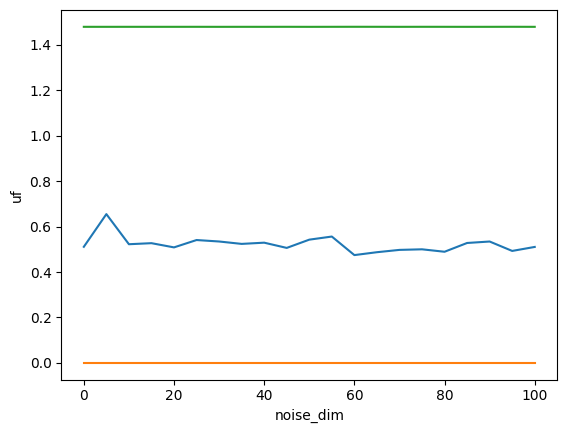

In [345]:
fig, ax = plt.subplots()
sns.lineplot(data=result_df, x="noise_dim", y="uf", ax=ax)
sns.lineplot(data=result_df, x="noise_dim", y="true", ax=ax)
sns.lineplot(data=result_df, x="noise_dim", y="ksg", ax=ax)